# Tuesday Health: Hospice Quality Metrics Technical Assessment
Author: Kyle Biron  

### Imports

In [82]:
import duckdb
import numpy
import pandas as pd
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# configure pandas to show full string values and all rows/columns
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

### Connect to db

In [83]:
# set duckdb directory path
db_dir = "/Users/kyle/Documents/personal_projects/repos/kyle-tuesday-health-tech-assignment/hospice_quality_metrics/db"

# connect to an existing duckdb database
con = duckdb.connect(f'{db_dir}/hospice_quality_metrics.db')

# list and print all tables in the connected duckdb database
tables = con.execute("SHOW TABLES").df()
print(tables)

                                              name
0                  fact_hospice_provider_flattened
1  fact_hospice_provider_missing_metrics_by_region
2                             stg_hospice_provider


### 1. Correlation Analysis: HIS Composite Process Metric & HCI Decile

#### load ```fact_hospice_provider_flattened``` to a df

- ```fact_hospice_provider_flattened``` is the flattened table from ```hospice_quality_metrics.db``` 
    - ```h_008_01_observed_score``` is the HIS Composite Measure
    - ```h_012_00_observed_score``` is the HCI Decile
- This dataframe will be used for the correlation analysis between the two measures
- Note that ```fact_hospice_provider_flattened``` only contains the CCNs that have BOTH measures populated
    - A side-analyis (see appendix) shows that out of the 7132 CCNs, **2765 (or ~39%)** of CCNs were excluded for this correlation analysis
    - CMS Region 9 (San Francisco: Arizona, California, Hawaii, Nevada, Pacific
Territories) was primarily impacted with this exclusion, as **63.36%** of their CCNs were missing at least one measure 

In [39]:
# use con.execute() to create a df
fact_hospice_provider_flattened_df = con.execute("SELECT * FROM fact_hospice_provider_flattened").df()

# preview the df
fact_hospice_provider_flattened_df.head(5)

,ccn,cms_region,h_008_01_observed_score,h_012_00_observed_score,h_008_01_observed_footnote,h_012_00_observed_footnote
0,331532,2,97.4,9.0,None,None
1,331535,2,99.7,9.0,None,None
2,331537,2,77.0,9.0,None,None
3,331540,2,92.1,10.0,None,None
4,331542,2,97.3,9.0,None,None


In [46]:
minus_query = '''
select count(distinct ccn) from stg_hospice_provider
'''

con.execute(minus_query).df()

,count(DISTINCT ccn)
0,7132


#### Examining the distribution of HIS Composite Measure and HCI Decile

- The plots below display the distribution for both measures
- Both measures appear right-skewed, with most of the CCNs "appearing" to perform well on both measures

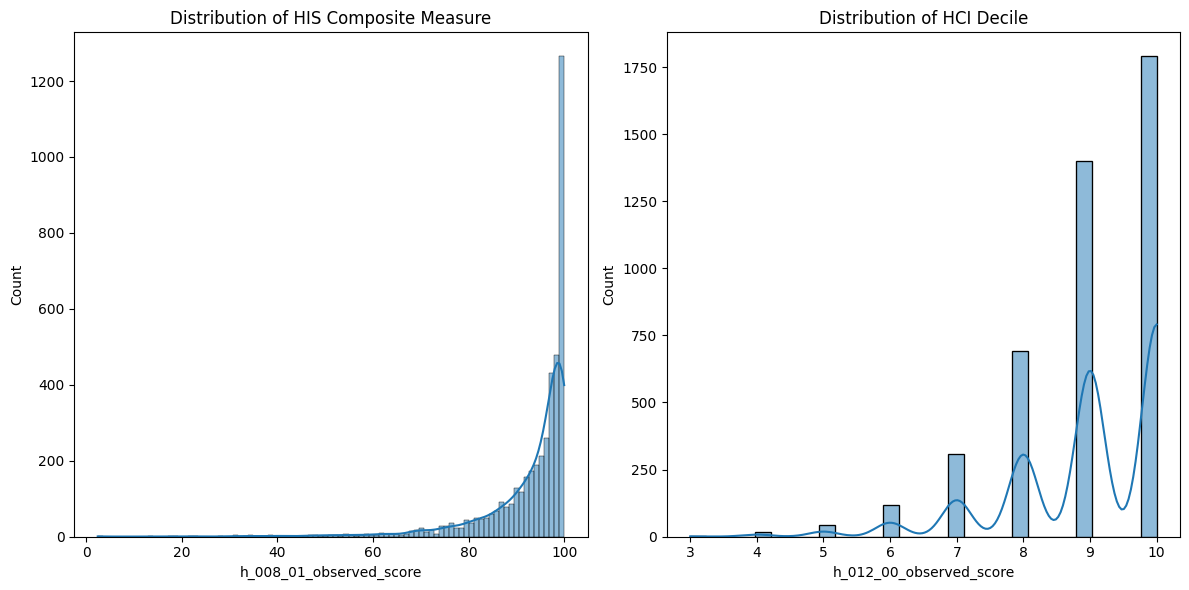

In [30]:
# configure subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# HIS Composite Measure plot
sns.histplot(data=fact_hospice_provider_flattened_df, x="h_008_01_observed_score", kde=True, ax=axes[0])
axes[0].set_title('Distribution of HIS Composite Measure')

# HCI Decile plot
sns.histplot(data=fact_hospice_provider_flattened_df, x="h_012_00_observed_score", kde=True, ax=axes[1])
axes[1].set_title('Distribution of HCI Decile')

# show plots
plt.tight_layout()
plt.show()

In [31]:
# pearson correlation
correlation_pearson = fact_hospice_provider_flattened_df[['h_008_01_observed_score', 'h_012_00_observed_score']].corr()

print("Correlation Matrix: Pearson")
print(correlation_pearson)

Correlation Matrix: Pearson
                         h_008_01_observed_score  h_012_00_observed_score
h_008_01_observed_score                 1.000000                 0.223246
h_012_00_observed_score                 0.223246                 1.000000


In [32]:
# Spearman correlation
correlation_spearman = fact_hospice_provider_flattened_df[['h_008_01_observed_score', 'h_012_00_observed_score']].corr(method='spearman')

print("Correlation Matrix: Spearman:")
print(correlation_spearman)

Correlation Matrix: Spearman:
                         h_008_01_observed_score  h_012_00_observed_score
h_008_01_observed_score                 1.000000                 0.227345
h_012_00_observed_score                 0.227345                 1.000000


In [33]:
correlation_spearman_by_region = fact_hospice_provider_flattened_df.groupby('cms_region')[
    ['h_008_01_observed_score', 'h_012_00_observed_score']
].corr(method='spearman')

print(correlation_spearman_by_region)

                                    h_008_01_observed_score  h_012_00_observed_score
cms_region                                                                          
1          h_008_01_observed_score                 1.000000                 0.174107
           h_012_00_observed_score                 0.174107                 1.000000
2          h_008_01_observed_score                 1.000000                 0.205653
           h_012_00_observed_score                 0.205653                 1.000000
3          h_008_01_observed_score                 1.000000                 0.253217
           h_012_00_observed_score                 0.253217                 1.000000
4          h_008_01_observed_score                 1.000000                 0.044258
           h_012_00_observed_score                 0.044258                 1.000000
5          h_008_01_observed_score                 1.000000                 0.155562
           h_012_00_observed_score                 0.155562      

### Appendix

####  CCNs without having both HIS and HCI by region

<Figure size 1000x600 with 0 Axes>

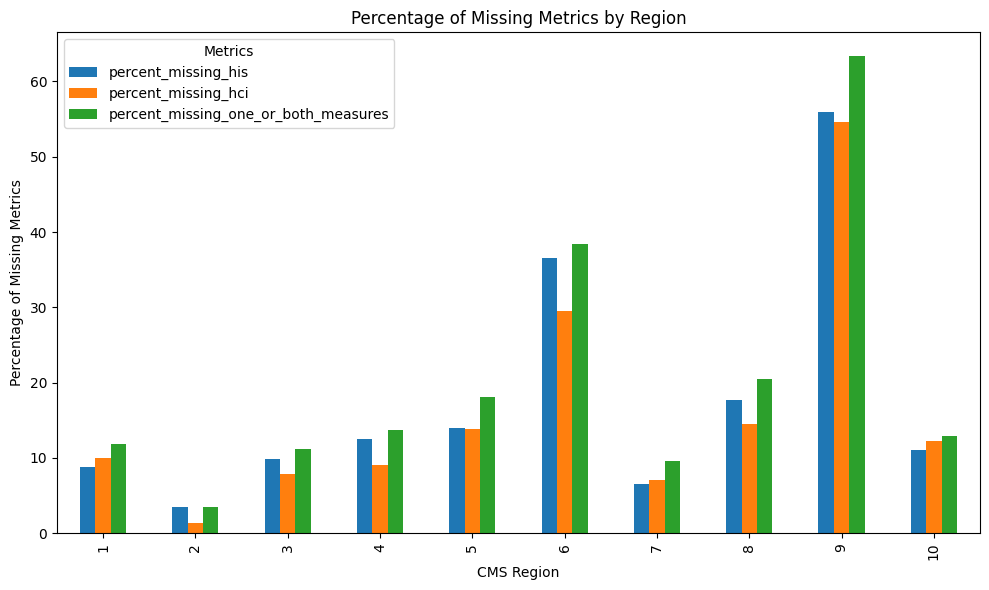

In [93]:
# use con.execute() to create a df
fact_hospice_provider_missing_metrics_by_region_df = con.execute("SELECT * FROM fact_hospice_provider_missing_metrics_by_region").df()

# sort df by cms_region
fact_hospice_provider_missing_metrics_by_region_df = fact_hospice_provider_missing_metrics_by_region_df.sort_values('cms_region')

# configure size
plt.figure(figsize=(10, 6))

# bar chart
fact_hospice_provider_missing_metrics_by_region_df.plot(
    kind='bar', 
    x='cms_region', 
    y=['percent_missing_his', 'percent_missing_hci', 'percent_missing_one_or_both_measures'], 
    figsize=(10, 6)
)

# configure title and labels
plt.title('Percentage of Missing Metrics by Region')
plt.xlabel('CMS Region')
plt.ylabel('Percentage of Missing Metrics')

# show plot
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()

In [85]:
adhoc_query = '''

select 
        *
    from fact_hospice_provider_missing_metrics_by_region
    order by 1

'''

con.execute(adhoc_query).df()

,cms_region,ccns_missing_his,ccns_missing_hci,ccns_missing_one_or_both_measures,total_ccn_count,percent_missing_his,percent_missing_hci,percent_missing_one_or_both_measures
0,1,14,16,19,160,8.75,10.00,11.88
1,2,5,2,5,144,3.47,1.39,3.47
2,3,35,28,40,358,9.78,7.82,11.17
3,4,90,65,99,722,12.47,9.00,13.71
4,5,100,99,129,716,13.97,13.83,18.02
5,6,516,417,544,1414,36.49,29.49,38.47
6,7,21,23,31,324,6.48,7.10,9.57
7,8,44,36,51,249,17.67,14.46,20.48
8,9,1614,1575,1826,2882,56.00,54.65,63.36
9,10,18,20,21,163,11.04,12.27,12.88


In [81]:
con.close()